In [61]:
import sys; sys.path

['/Users/sahal/Documents/code/scotiabankfrauddetection',
 '/Users/sahal/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles',
 '/Users/sahal/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python',
 '/Users/sahal/miniconda3/envs/tf/lib/python310.zip',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10/lib-dynload',
 '',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10/site-packages']

Imports that we are using

In [62]:
import os 
import warnings

import numpy as np
import tensorflow as tf
import pandas as pd
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition


#visuals
import seaborn as sns
import matplotlib.pyplot as plt


Checking to see that tensorflow works. Your output should contain a tf.tensor

In [63]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(887.69824, shape=(), dtype=float32)


Preliminary Graphing

In [64]:
#Loading the dataset - abel
url = "https://raw.githubusercontent.com/25ohms/scotiabankfrauddetection/main/Winter%202023%20Discovery%20Days/train_ScotiaDSD.csv"
data = pd.read_csv(url)




credible_data = data[data['FRAUD_FLAG'] == 0.0] 
fraudulent_data = data[data['FRAUD_FLAG'] == 1.0]

In [65]:
print(credible_data.head())

   EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
1            2                  4      12:51       8352728b         0.0   
2            2                  4      15:26       d50120e1         0.0   
3            2                  4      16:19       e96e2139         0.0   
4            2                  4      8:15:       32502a99         0.0   
5            2                  4      16:27       1b4856fb         0.0   

   AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
1    20371.88   96.35       30700.0                 1   
2    15628.17  193.72       19500.0                 0   
3    12913.98   47.15       18400.0                 0   
4    26779.35  121.88       29200.0                 1   
5    27484.35    6.83       30700.0                 0   

                                          USER_AGENT  ...  \
1  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...  ...   
2                                                NaN  ...   
3                      

In [66]:
print(fraudulent_data.head())

     EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
0              2                  4      14:16       a316accb         1.0   
24             2                  4      20:02       5fcc42f8         1.0   
36             2                  4      19:59       0d060041         1.0   
38             2                  4      12:30       74bbbe44         1.0   
132            2                  4      16:28       c264fb24         1.0   

     AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
0        537.10   11.70       29200.0                 1   
24      9016.80   50.23       21400.0                 1   
36      3135.47   41.00       19500.0                 1   
38       674.70  161.95        1000.0                 1   
132     1314.30   44.08        5100.0                 1   

                                            USER_AGENT  ...  \
0                                                  NaN  ...   
24   Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...  

Checking to see if Data is null

In [67]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,USER_AGENT,CITY,EVENT_MONTH,MAX_PHONE_ORDER_PAST_30DAY,MEAN_TRAVEL_AND_ENTERTAINMENT_PAST_30DAY,MEAN_WEEKEND_PAST_30DAY,MAX_AUTO_PAST_30DAY,MAX_LS_PAST_30DAY,MAX_ELCTRNCS_PAST_30DAY,MAX_FASTFOOD_PAST_30DAY,...,MAX_RECREA_PAST_7DAY,MAX_HIGH_AMT_PAST_7DAY,MAX_HIGH_RECREA_PAST_7DAY,MAX_INTERNET_PAST_7DAY,MAX_PHONE_ORDER_PAST_7DAY,MAX_PURCHASE_EXCLUDING_GAS_PAST_7DAY,MAX_SWIPE_PAST_7DAY,MAX_WEEKEND_PAST_7DAY,STD_LX_PAST_7DAY,PREV_M_UNEMP_RATE
Total,77322.000000,77322.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,86.654713,86.654713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
num_fraudulent = fraudulent_data.shape[0]
num_total = data.shape[0]

p_fraudulent = num_fraudulent / num_total
print(p_fraudulent)

0.024139863274683402


Suggests that the data is heavily unbalanced.

In [33]:
print(data.shape)

(89230, 175)


\section{Using PCA on Data}

In [69]:
response_train = data['FRAUD_FLAG']
explanatory_train = data.drop(['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 
    'FRAUD_FLAG','AVAIL_CRDT', 'AMOUNT', 'CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND'], axis=1)
bernoulli_catergorical_train = data[['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 
      'AVAIL_CRDT', 'AMOUNT', 'CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND']]
print(response_train.head())
print(explanatory_train.head())

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FRAUD_FLAG, dtype: float64
   CREDIT_LIMIT  MEAN_AUTO_PAST_7DAY  MEAN_LS_PAST_7DAY  \
0       29200.0                46.65               0.00   
1       30700.0                 0.00               0.00   
2       19500.0                 0.00               0.00   
3       18400.0                23.40             123.58   
4       29200.0                 4.61               0.00   

   MEAN_RECREA_PAST_7DAY  MEAN_REG_AMT_PAST_7DAY  MEAN_FASTFOOD_PAST_7DAY  \
0                1600.03                  158.88                     0.00   
1                   0.00                  243.75                     0.00   
2                 113.26                 2305.18                    22.55   
3                  66.91                   78.00                     0.00   
4                   0.00                    0.00                     0.00   

   MEAN_HIGH_AMT_PAST_7DAY  MEAN_HIGH_RECREA_PAST_7DAY  \
0                  1034.48                    

In [70]:
print(bernoulli_catergorical_train.head())

   EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  AVAIL_CRDT  \
0            2                  4      14:16       a316accb      537.10   
1            2                  4      12:51       8352728b    20371.88   
2            2                  4      15:26       d50120e1    15628.17   
3            2                  4      16:19       e96e2139    12913.98   
4            2                  4      8:15:       32502a99    26779.35   

   AMOUNT  CARD_NOT_PRESENT  \
0   11.70                 1   
1   96.35                 1   
2  193.72                 0   
3   47.15                 0   
4  121.88                 1   

                                          USER_AGENT      CITY  FLAG_LX  ...  \
0                                                NaN       NaN        0  ...   
1  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...   lasalle        0  ...   
2                                                NaN       NaN        0  ...   
3                                         

In [71]:
standarized_data = StandardScaler().fit_transform(explanatory_train)
pca = decomposition.PCA(n_components=28)
pca_data = pca.fit_transform(standarized_data)
print(pca_data)


[[ 2.50407296e+01 -1.53315839e+00 -6.60782146e-01 ...  1.71594159e+00
  -1.97972258e-01 -3.15504847e+00]
 [ 5.03842661e+00 -1.66233301e+00 -3.31565196e+00 ...  1.45869559e+00
   1.06071571e+00  4.04107460e-02]
 [ 1.40154719e+01  2.83148011e+00 -7.28575387e+00 ... -1.49123633e-02
   1.07253598e+00 -1.72738313e+00]
 ...
 [-3.97132990e+00  2.73424455e+00 -7.67776625e-01 ... -3.18765730e-01
  -2.21318545e-01 -1.78539448e-01]
 [ 5.08861758e-01  2.36152055e-01 -1.57216175e+00 ...  8.80365675e-01
   1.55937540e-01  5.99679612e-01]
 [ 1.94388055e+00 -1.82353600e+00  2.06497190e+00 ...  7.66380820e-01
   7.56317131e-01  6.66026650e-01]]


\subsection{Scree Plot}
Determining number of factors we wish to use in our exploratory factor analysis to keep in a PCA.

Text(0, 0.5, 'Retention value on scale of 1')

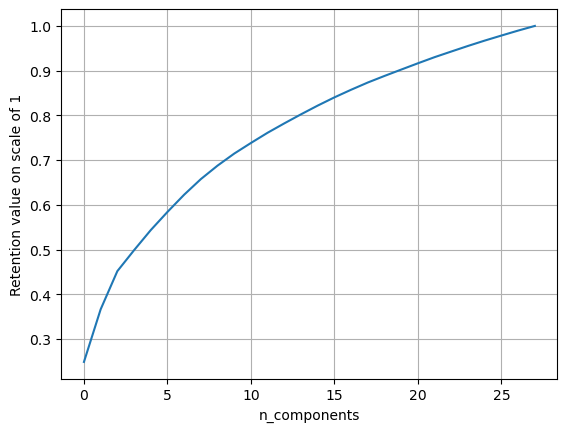

In [72]:
pca.n_components = 139

retention_value = pca.explained_variance_ / np.sum(pca.explained_variance_);
cumulative_retention = np.cumsum(retention_value)

plt.plot(cumulative_retention)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Retention value on scale of 1')

In [73]:
print(pca_data.shape)

(89230, 28)
